# Modeling
___

This model is created using title and selftext together.

Below is a Logisitc Regression Model using a Pipeline and Count Vectorization. Accuracy = 94.4%.

---

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import sklearn.metrics as metrics

## Load the data
---

In [2]:
df = pd.read_csv('../../data/data_clean_combo_20220302-111425.csv')
df.drop(columns = 'Unnamed: 0', inplace=True)
df.head()

,author,title,selftext,created_utc,title_selftext,title_text_length,title_text_word_count,subreddit_target
0,RealDaveCorey,"Trying to straighten my leaning garage, was th...","Hi, I'm looking at torturing my leaning garage...",1645985955,trying to straighten my leaning garage wa the ...,1136,219,0
1,ZeroCool1,Thoughts from two years into purchasing a fixe...,A few random thoughts after I've wrestled with...,1645985873,thought from two year into purchasing a fixer ...,4077,816,0
2,gwenstellamade,HELP! Fireplace contractors screwed up the job,"So, I’m in a bit of a pickle with my current f...",1645985865,help fireplace contractor screwed up the jobso...,1795,351,0
3,happybaconbit,Kitchen cabinet track is broken. How do I fix it?,Photo: https://imgur.com/a/XgNq0iG \n\nIt’s be...,1645985826,kitchen cabinet track is broken how do i fix i...,248,55,0
4,stonetime10,OTR microwave with stud In the way,"Hello everyone,\nI am almost finished my basem...",1645985457,otr microwave with stud in the wayhello everyo...,709,139,0


## Create X and y
---

In [3]:
X = df['title_selftext']
X.head()

0    trying to straighten my leaning garage wa the ...
1    thought from two year into purchasing a fixer ...
2    help fireplace contractor screwed up the jobso...
3    kitchen cabinet track is broken how do i fix i...
4    otr microwave with stud in the wayhello everyo...
Name: title_selftext, dtype: object

In [4]:
y = df['subreddit_target']

## Baseline Accuracy
---

In [5]:
y.value_counts(normalize = True)

0    0.502137
1    0.497863
Name: subreddit_target, dtype: float64

It is essentially a 50/50 split. There is a slight preference towards HomeImprovement. So the baseline/null model will predict HomeImprovement and be accurate about 50% of the time. 

## Train - Test Split
---

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33, stratify = y)

Want to keep the split to about 50/50 for the model, hence why this is being stratified.

## Pipeline
---
Will start with a pipeline including Count Vectorization and a logistic regression model.

In [7]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('logreg', LogisticRegression(solver = 'liblinear'))
])

## GridSearchCV
___

In [8]:
params ={
    'vect__stop_words': ['english'], #removed none
    'vect__min_df': range(1, 10, 2), 
    'vect__max_df': [1.0, 0.75, 0.5, 0.25], 
    'vect__binary': [True], #removed False
    'vect__ngram_range':[(1,3)], #removed (1,1) and (1,2)
    'vect__max_features': [4000], #took out 1000, 1500, 2000, 30000
    'logreg__penalty': ['l2'] #took out l1.
}

gs = GridSearchCV(pipe,
                 param_grid=params)

gs.fit(X_train, y_train)
print(gs.best_score_) 
gs.best_params_

0.9510421233685203


{'logreg__penalty': 'l2',
 'vect__binary': True,
 'vect__max_df': 0.25,
 'vect__max_features': 4000,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 3),
 'vect__stop_words': 'english'}

## Model Evaluation
---

Using the GridSearch model above. 

In [9]:
y_pred = gs.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

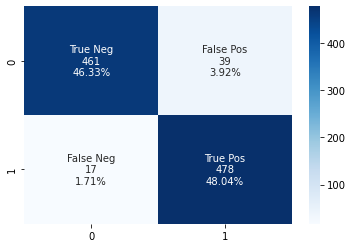

In [10]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

The below function was created by Dennis T, a contributor on the Medium blog Towards Data Science. He explained in this [blog post](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea) how to use the code and supplied it [here](https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py).

In [11]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

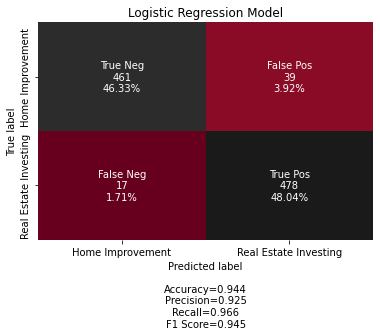

In [19]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Home Improvement', 'Real Estate Investing']

make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='RdGy',
                      cbar=False,
                     title = 'Logistic Regression Model')

plt.savefig("../../images/logreg_matrix.jpg", bbox_inches="tight", dpi=100);

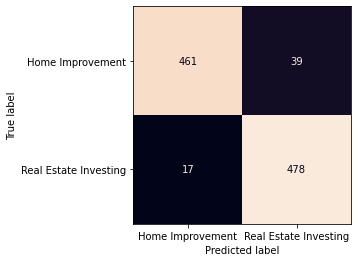

In [20]:
plot_confusion_matrix(gs, X_test, y_test, display_labels= ['Home Improvement', 'Real Estate Investing'], colorbar=False, cmap='rocket')

In [21]:
trainscore = gs.score(X_train, y_train)
testscore = gs.score(X_test, y_test)
crossval = cross_val_score(gs, X_train, y_train).mean()
preds = gs.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
recall = metrics.recall_score(y_test, preds)
precision = metrics.precision_score(y_test, preds)
accuracy = testscore
specificity = tn / (tn + fp)

print (f'Train Score = {trainscore}')
print (f'Test Score = {testscore}')
print (f'Cross Val Score = {crossval}')
print (f'Accuracy Score = {testscore}')
print (f'Recall Score = {recall}')
print (f'Precision Score = {precision}')
print (f'Specificity Score = {specificity}')

Train Score = 0.9916163648558015
Test Score = 0.9437185929648241
Cross Val Score = 0.9503704203343337
Accuracy Score = 0.9437185929648241
Recall Score = 0.9656565656565657
Precision Score = 0.9245647969052224
Specificity Score = 0.922


The Logistic Regression model using title/self-text performs much better than the Logitistic Regression model using the title only. It has an accuracy score of 94.4% versus 91.4%. This means that the model is 94.4% accurate at predicting which subreddit the text comes from, either Real Estate Investing or Home Improvement.

The recall score is very strong. This means that out of all of the actual Real Estate Investing posts, the model accuractely predicted 96.6% of them correctly. 

The precision score is strong, but not as strong as the recall score. The means that out of all of the predicions for Real Estate Investing, 92.5% of them were accurate predictions. 

The specificity score is the lowest of all of the scores. This means that out of all of the actual Home Improvement posts, the model accurately predicted 92.2% of them correctly.

There are more False Positives, meaning that more posts were predicted to be in Real Estate Investing when they were actually in Home Improvement. 

In [22]:
#Gives coefficients for the model. Remember that these are logs and difficult to interpret. Will only focus on the larger the value, the more important.
gs.best_estimator_.named_steps['logreg'].coef_[0]

array([0.23649854, 0.01007716, 0.36206634, ..., 0.53955348, 0.09674031,
       0.2121139 ])

In [24]:
logreg_coef = pd.Series(gs.best_estimator_.named_steps['logreg'].coef_[0], index = gs.best_estimator_.named_steps['vect'].get_feature_names()).sort_values(ascending = False)[:25]

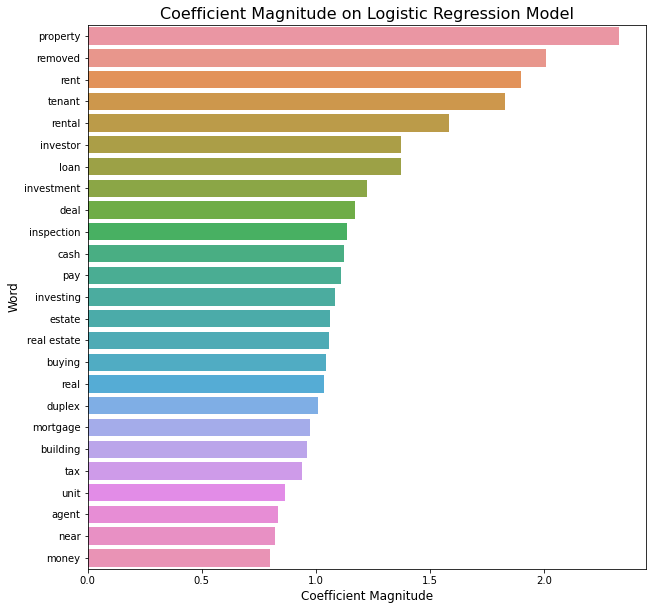

In [46]:
plt.figure(figsize = (10, 10))
sns.barplot(x = logreg_coef, y = logreg_coef.index)
plt.title('Coefficient Magnitude on Logistic Regression Model', fontdict = {'fontsize': 16})
plt.xlabel('Coefficient Magnitude', fontdict = {'fontsize': 12})
plt.ylabel('Word', fontdict = {'fontsize': 12});
plt.savefig("../../images/logreg_coef.jpg", bbox_inches="tight", dpi=100);

These are the coefficients for the Logistic Regression model. Larger coefficients mean that the feature was more important to the model and carried a larger impact. 

## Probability DataFrame - Predictions vs Actual
---
The below is credited to Shania Thomas. The dataframe below show the probability for each subreddit on each document. The last dataframe shows the documents that received the *most* wrong probabilities. If time allows, I will dig into why these documents were possibly misclassified.

In [ ]:
preds_df = pd.DataFrame({
    'title_selftext' : X_test, 
    'actual' : y_test, 
    'predicted' : gs.predict(X_test),
    'P(r/HomeImprovement)' : [i[0] for i in gs.predict_proba(X_test)],
    'P(r/RealEstateInvesting)' : [i[1] for i in gs.predict_proba(X_test)]})
preds_df['Prob Diff'] = np.abs(preds_df['P(r/RealEstateInvesting)'] - preds_df['P(r/HomeImprovement)'])
preds_df

In [34]:
pd.set_option('display.max_colwidth', None)
wrong_preds_df = preds_df[preds_df['actual']!=preds_df['predicted']]
very_wrong_preds_df = wrong_preds_df[wrong_preds_df['Prob Diff']>0.5]
very_wrong_preds_df.sort_values(by='P(r/RealEstateInvesting)', ascending=False).head(10)

,title_selftext,actual,predicted,P(r/HomeImprovement),P(r/RealEstateInvesting),Prob Diff
457,code enforcement invading the neighborhood now what i live next to a motorcycle club they re great people and a welcome presence in the neighborhood not a single conflict in the 3 year i ve lived here or in the past decade according to other neighbor however they have quite a few structure on their property that are not permitted most of which have been there 20 year or longer a few trailer rv porch awning etc someone bought up a number of vacant lot in the neighborhood we suspect to build rental property and decided that their first step wa to call code enforcement on the club code enforcement gave them a dozen citation and 6 week to get compliant or 1000 daily fine will begin the club is complying and removing all of their structure however the code enforcement officer decided to a clean sweep of the entire neighborhood while they were here they knocked on several door citing people for improperly placed trash can un permitted railing on porch canopy tent in people s backyard and a variety of other violation that seem quite ridiculous given the context of the neighborhood code enforcement ha not been in this neighborhood in decade according to neighbor who ve lived here since the 1980s keep in mind no one who life in this neighborhood actually called code enforcement code enforcement explicitly told u that the only complaint they have wa filed against the bike club and it wa not by a resident of the neighborhood this feel a lot like an overreach on their part a the entire community is content with the bike club i ve spoken to every neighbor on my street and none of them are happy that code enforcement is here with that said is there anything can be done about this it feel like a stranger came to our community reported the violation they saw having never actually lived here and now we re dealing with multiple officer nitpicking the entire block over arbitrary violation everyone is frustrated stressed out and simply want to be left alone are we just totally screwed,0,1,0.013883,0.986117,0.972233
1922,alternate project management contractor love to come in and do large renovation and charge you can have a better and cheaper result by cutting the project into manageable piece if you have time be your own project manager i say better because change can be made on the fly without extra charge when you find surprise you can deal with them in your own time and budget you will find surprise doing work that need a permit usually only a specific part of your project need permitting and inspecting if an inspector come and work ha been done in a large area then they will inspect all the work get the project ready for your tradesman then when the inspection time come they can tell the inspector what work they performed and the rest wa already there do a much of the work yourself a you can demo prep cleanup all that cost money to pay someone else to do talk to lot of people watch video you don t need to know an entire trade to do small thing if you read this i apologize for my poor writing skill hope it help with someone s home improvement good luck,0,1,0.023141,0.976859,0.953718
966,should i get expensive window for a rental unit are expensive window worth putting in a rental unit from what i ve read it would take about 10 year to make back the money on energy saved but i m not paying utility anyway,0,1,0.028582,0.971418,0.942837
581,finding out about fire damage to a house canada i m based in canada and looking to buy my first house is there a way to proactively find out about any fire that could have occurred in the past besides relying on the house inspection can you find out this information from the city or fire department an acquaintance of mine bought a house that had fire damage some time ago this wa not disclosed to her and the inspector did not pick up on it so i m a little wary,0,1,0.068711,0.931289,0.862577
124,real estate developerthi